# Aprendizaje Automático

## Proyecto

Profesor: MSc. Felipe Meza.

Instituto Tecnológico de Costa Rica, 

Medio de entrega: TecDigital.

Entregables: El entregable consiste en el url de la notebook Proyecto.ipynb en GITHUB. 

Grupo de trabajo:
- Manuel Calderón
- Ernesto Rivera

---
Objetivo: El objetivo del Proyecto consiste en hacer un análisis de un conjunto de datos.

# Manejo y preprocesado de datos


Para el ejemplo de los algoritmos supervisados se escogió el dataset de Agora.csv, utilizado en la tarea 2, ya que proporciona bastantes datos a trabajar.

En las siguientes tres celdas:
- Se importan las bibliotecas necesarias para este documento
- Se lee el archivo **Agora.csv** y se eliminan errores de tabulado usando sustituciones textuales. El resultado final se guarda en el archivo **Agora2.csv**.
- Se carga **Agora2.csv** en un dataframe de pandas.
- Se eliminan los outliers y se convierten los features _Price_ y _Rating_ datos de texto a numéricos, y se eliminan los features que no interesan.
- Se procesa el feature de _Category_ y se transforma usando _one hot encoding_.
- Toma el _Rating_ y se crean categorías o clases.
- Definir valores de entrada y target.

### Importar bibliotecas

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint, EarlyStopping

from matplotlib import pyplot as plt
%matplotlib inline

### Creación de métodos auxiliares
Las siguientes celdas contienen funciones de:
- agrupamiento de datos,
- reorganización de datos en variables,
- creación del modelo de red neuronal,
- o para graficar.

In [2]:
## Toma los valores del dataframe y los agrupa por producto
## y por fecha
## sumando las cantidades.
## Salida:  dos DataFrames: entradas, salidas de inventiario
def agruparCantidadPorProducto(df):
    dataEntradas = {}
    dataSalidas = {}
    for index, row in df.iterrows():
        name = row['Producto/Nombre'] + str(row['Creado en'])
        data = dataEntradas if row['Cantidad'] >= 0 else dataSalidas
        if not name in data:
            data.update({name:{'Creado en': row['Creado en'], 
                               'Producto/Nombre': row['Producto/Nombre'],
                               'Cantidad': row['Cantidad']}})
        else:
            data[name].update({'Cantidad': row['Cantidad'] + data[name]['Cantidad']})

    listEntradas, listSalidas = [],[]
    for ind in dataEntradas:
        listEntradas.append(dataEntradas[ind])
    for ind in dataSalidas:
        listSalidas.append(dataSalidas[ind])
    
    return pd.DataFrame(listEntradas), pd.DataFrame(listSalidas)

In [3]:
def convert2matrix(dataset, look_back=1):
    X, Y =[], []
    for i in range(len(dataset)-look_back):
        d=i+look_back  
        X.append(dataset[i:d,0])
        Y.append(dataset[d,0])
    return np.array(X), np.array(Y)

In [4]:
def neural_model(look_back, trainX, trainY, epochs, batch_size):
    model = Sequential()
    model.add(Dense(32, input_dim=look_back, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(testX,testY), 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10)],shuffle=False)
    return model, history


In [5]:
def history_model_plot(dataset, look_back, trainPredict, testPredict):
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+look_back:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    plt.plot(dataset, label='Datos base')
    plt.plot(trainPredictPlot, label='Predicción de entrenamiento')
    plt.plot(testPredictPlot, label='Predicción de prueba')
    plt.legend()
    plt.show()

In [6]:
def graficar_model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida en pruebas')
    plt.title('Pérdida del modelo')
    plt.ylabel('Pérdida')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [7]:
def prediction_plot(testY, test_predict, l):
    len_prediction=[x for x in range(len(testY))]
    plt.figure(figsize=(8,4))
    plt.plot(len_prediction, testY[:l], marker='.', label="Datos base")
    plt.plot(len_prediction, test_predict[:l], 'r', label="Predicción")
    plt.tight_layout()
    
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Cantidad')
    plt.xlabel('Tiempo')
    plt.legend(loc='upper right')
    plt.show();


In [19]:
def graficarPorCat(data, columnaCategorica, columnaX, columnaY):
    valoresUnicos = data[columnaCategorica].unique()
    
    # 2 columnas de gráficos
    colsEnGrafico = 2
    filasEnGrafico = math.ceil(valoresUnicos.size / colsEnGrafico)
    fig, axes = plt.subplots(filasEnGrafico, colsEnGrafico, figsize=(16,16))
    # aplanar la lista para recorrerla consecutivamente
    axes = np.concatenate(axes).ravel()

    for indice in range(valoresUnicos.size):
        valor = valoresUnicos[indice]
        axis = axes[indice]
        dataUnica = data[data[columnaCategorica] == valor]
        
        axis.tick_params(axis='x', labelrotation=30)
        axis.plot(dataUnica[columnaX], dataUnica[columnaY])
        axis.set_title(valor)
    
    fig.suptitle("'" + columnaY + "' x '" + columnaCategorica + "'")
    
    plt.tight_layout()
    plt.show()

###  Cargar los datos

In [20]:
df = pd.read_csv('data_con_masc.csv')
df.head(5)

,Producto/Nombre,Cantidad,Cantidad restante,Creado en,Categoría de producto/Nombre completo,Categoría de producto/Nombre mostrado,Movimiento stock/Ubicación origen/Nombre ubicación,Movimiento stock/Ubicación origen/Nombre mostrado,Movimiento stock/Ubicación destino/Nombre ubicación,Movimiento stock/Ubicación destino/Nombre mostrado
0,Producto base 1,-1.840000e+03,0.0,2021-09-13 23:21:00,Categoría 1,Categoría 1,Stock,fis_2/Stock,Fabricación,Ubicaciones virtuales/Fabricación
1,Producto base 1,-1.840000e+03,0.0,2021-09-13 23:21:00,Categoría 1,Categoría 1,Stock,fis_2/Stock,Fabricación,Ubicaciones virtuales/Fabricación
2,Producto base 1,3.680000e+03,0.0,2021-09-13 23:20:51,Categoría 1,Categoría 1,Fabricación,Ubicaciones virtuales/Fabricación,Stock,fis_2/Stock
3,Producto base 1,1.270020e-13,0.0,2021-09-12 14:21:48,Categoría 1,Categoría 1,NaN,NaN,NaN,NaN
4,Producto base 1,-7.530000e+02,0.0,2021-09-11 16:54:07,Categoría 1,Categoría 1,Stock,fis_2/Stock,Fabricación,Ubicaciones virtuales/Fabricación


In [9]:
df.describe()

,Cantidad,Cantidad restante
count,15817.000000,15817.000000
mean,9.343426,9.343426
std,12551.471255,826.509531
min,-383000.000000,0.000000
25%,-160.000000,0.000000
50%,-5.000000,0.000000
75%,1.000000,0.000000
max,836270.000000,100102.828000


In [10]:
print(df.columns)
df['Creado en'].head(10)

Index(['Producto/Nombre', 'Cantidad', 'Cantidad restante', 'Creado en',
       'Categoría de producto/Nombre completo',
       'Categoría de producto/Nombre mostrado',
       'Movimiento stock/Ubicación origen/Nombre ubicación',
       'Movimiento stock/Ubicación origen/Nombre mostrado',
       'Movimiento stock/Ubicación destino/Nombre ubicación',
       'Movimiento stock/Ubicación destino/Nombre mostrado'],
      dtype='object')


0    2021-09-13 23:21:00
1    2021-09-13 23:21:00
2    2021-09-13 23:20:51
3    2021-09-12 14:21:48
4    2021-09-11 16:54:07
5    2021-09-11 16:54:01
6    2021-09-11 16:54:01
7    2021-09-10 22:39:49
8    2021-09-10 22:39:49
9    2021-09-10 22:39:49
Name: Creado en, dtype: object

Los datos están ordenados por fecha descendente. Para efectos de graficación vamos a revertir este orden, esto incluye volver a hacer el índice del dataframe.

In [23]:
df = df[::-1].reset_index(drop=True)
df['Creado en'].head(10)

0    2018-08-04 15:24:15
1    2018-08-06 23:35:42
2    2018-08-12 21:58:08
3    2018-08-13 23:02:35
4    2018-08-20 20:53:59
5    2018-08-31 19:59:18
6    2018-09-01 02:02:19
7    2018-09-01 09:02:36
8    2018-09-01 15:16:19
9    2018-09-03 10:17:41
Name: Creado en, dtype: object

### Limpiar datos y manejar tipos de datos
Consiste en eliminar columnas que no se van a usar.  Además cambiar la colummna _Creado en_ para que tenga el tipo de datos que se ocupan.

También, se redondea los valores en la columna _Cantidad_ y se eliminan las filas donde la _Cantidad_ sea cero, pues significa que no hubo movimiento en el inventario.

In [24]:
# Se eliminan columnas innecesarias Cantidad restante,Categoría de producto/Nombre mostrado, 
# Movimiento stock/Ubicación origen/Nombre ubicación, Movimiento stock/Ubicación destino/Nombre ubicación

df.drop(columns=["Cantidad restante", "Categoría de producto/Nombre mostrado", 
                 "Movimiento stock/Ubicación origen/Nombre ubicación",
                 "Movimiento stock/Ubicación origen/Nombre mostrado",
                 "Movimiento stock/Ubicación destino/Nombre mostrado",
                 "Movimiento stock/Ubicación destino/Nombre ubicación"], inplace=True)
print('Columnas restantes:', df.columns)

# Solo nos interesa el año y el mes
df['Creado en'] = pd.to_datetime(df['Creado en'].str.slice(0,7), format="%Y-%m", errors='ignore')


# Redondeo de columnas a 4 decimales e eliminiacion de los 0
df = df.round({"Cantidad": 4})
df = df[df["Cantidad"] != 0]

# Quitando datos del último mes de los datos, pues no están los datos completos
df = df[df['Creado en'] < pd.Timestamp(2021, 9, 1)]

df.describe()

Columnas restantes: Index(['Producto/Nombre', 'Cantidad', 'Creado en',
       'Categoría de producto/Nombre completo'],
      dtype='object')


,Cantidad
count,14683.000000
mean,10.065039
std,13027.177926
min,-383000.000000
25%,-234.600000
50%,-7.000000
75%,15.000000
max,836270.000000


### Entradas y Salidas de inventario

Se separa el dataset en 2 para su análisis: Las cantidades positivas son _Entradas_ y negativas son _Salidas_.

Las _Salidas_ se pasan a positivo para su respectivo análisis.

In [27]:
# Se separan el dataset en 2
df_in_pr, df_out_pr = agruparCantidadPorProducto(df)
# Salidas a cantidades positivas
df_out_pr['Cantidad'] = df_out_pr['Cantidad'] * -1
df_in_pr

,Creado en,Producto/Nombre,Cantidad
0,2018-08-01,Producto base 5,36011.160
1,2018-09-01,Producto base 5,42020.590
2,2018-10-01,Producto base 5,18000.000
3,2018-11-01,Producto base 5,42000.000
4,2018-12-01,Producto base 5,24000.000
...,...,...,...
333,2021-05-01,Producto base 1,135650.275
334,2021-06-01,Producto base 1,147469.000
335,2021-07-01,Producto base 1,145354.000
336,2021-08-01,Producto base 1,140732.000


Visualización de las entradas por producto al inventario.

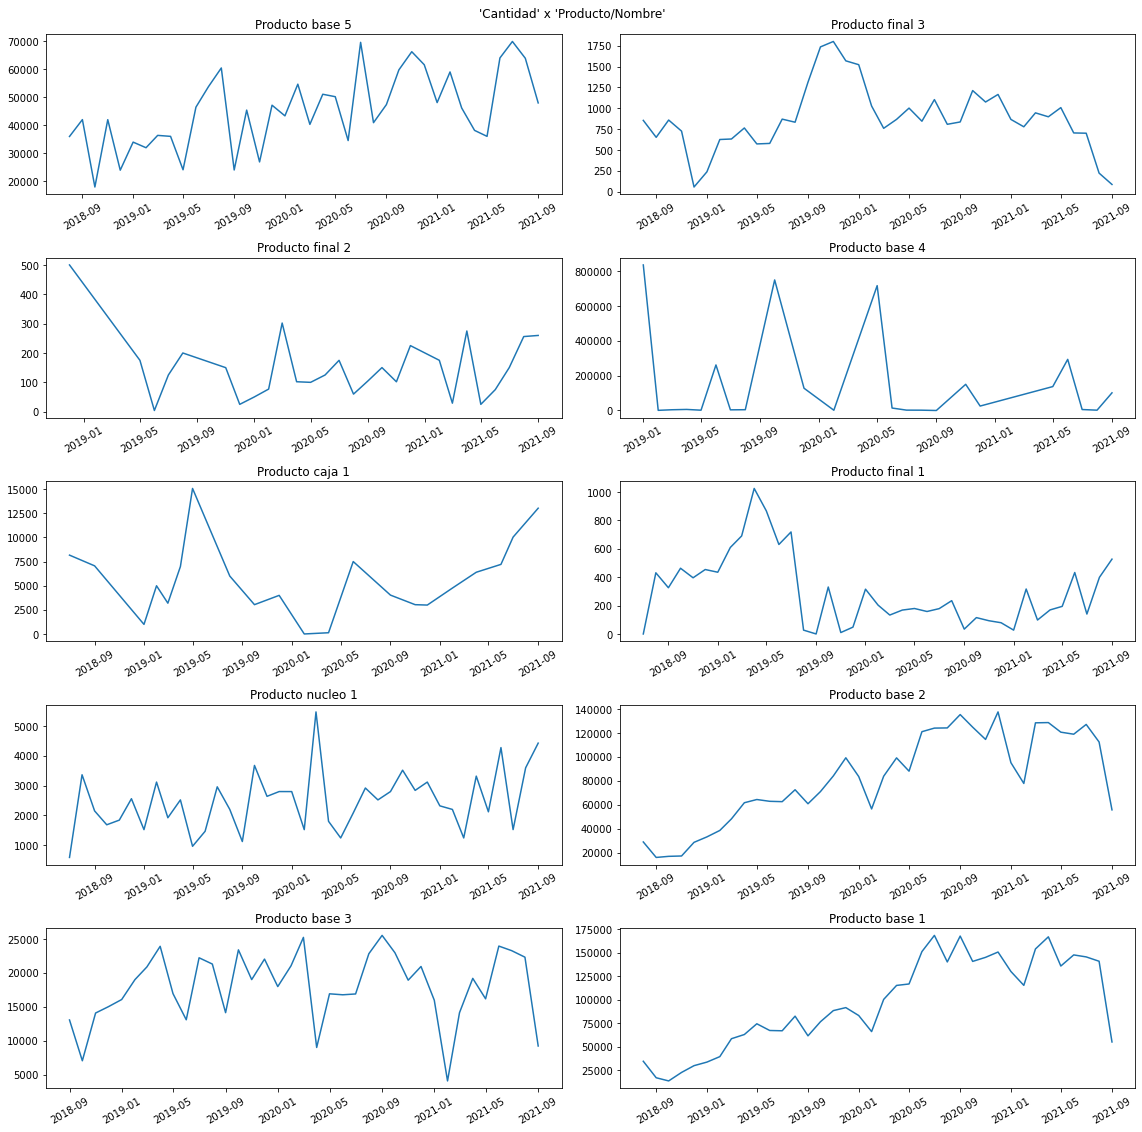

In [28]:
graficarPorCat(df_in_pr, "Producto/Nombre", "Creado en", "Cantidad")

### Análisis de las entradas de un producto 
Se inicia con el análisis de un solo producto, cuyo nombre es _Producto base 1_.

In [31]:
new_df_in_pr = df_in_pr[df_in_pr["Producto/Nombre"] == 'Producto base 1'] 
new_df_in_pr = new_df_in_pr.drop(columns=["Creado en", "Producto/Nombre"])

new_df_in_pr['Cantidad'] = MinMaxScaler().fit_transform(np.array(new_df_in_pr['Cantidad']).reshape(-1,1))

new_df_in_pr.describe()

dataset = new_df_in_pr.values

In [17]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

look_back = 1
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

model, history = neural_model(trainX.shape[1], trainX, trainY, 300, 20)

In [33]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f MAE)' % (trainScore[0], trainScore[1]))

testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f MAE)' % (trainScore[0], trainScore[1]))

Train Score: 0.02 MSE (0.10 MAE)
Test Score: 0.02 MSE (0.10 MAE)


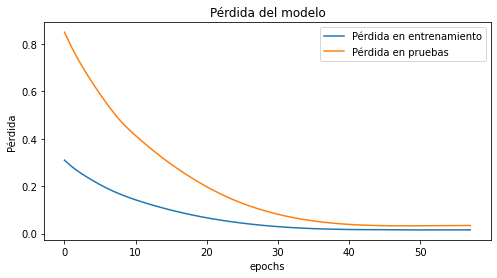

In [41]:
graficar_model_loss(history)

In [42]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

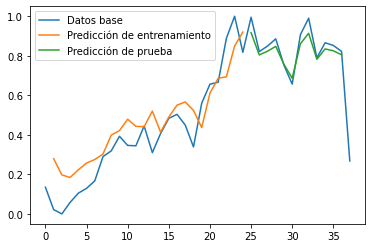

In [45]:
history_model_plot(dataset, look_back, trainPredict, testPredict)

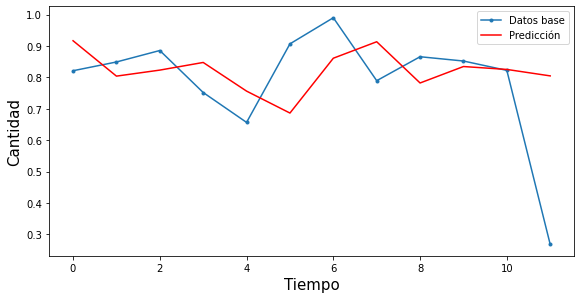

In [48]:
prediction_plot(testY, testPredict, testY.shape[0])

### Análisis de las Salidas de un producto 
Continuando con el análisis anterior, se procede esta vez a analizar las salidas del producto cuyo nombre es _Producto base 1_.

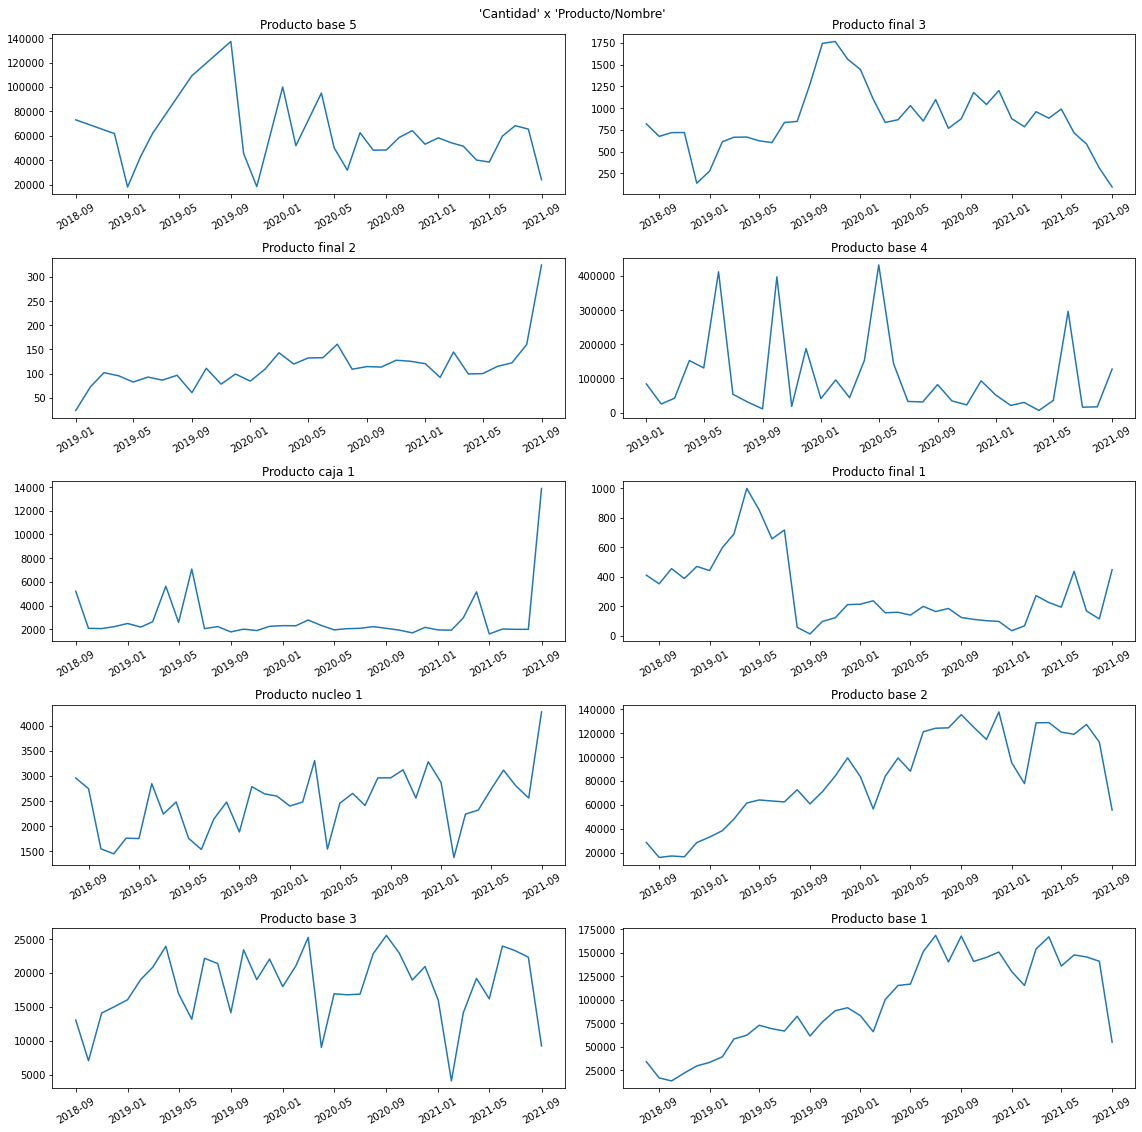

In [59]:
graficarPorCat(df_out_pr, "Producto/Nombre", "Creado en", "Cantidad")

In [52]:
new_df_out_pr = df_out_pr[df_out_pr["Producto/Nombre"] == 'Producto base 1'] 
new_df_out_pr = new_df_out_pr.drop(columns=["Creado en","Producto/Nombre"], inplace=False)

new_df_out_pr['Cantidad'] = MinMaxScaler().fit_transform(np.array(new_df_out_pr['Cantidad']).reshape(-1,1))

new_df_out_pr.describe()

dataset = new_df_out_pr.values

In [29]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape dataset
look_back = 1
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

model, history = neural_model(trainX.shape[1], trainX, trainY, 300, 20)

In [30]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f MAE)' % (trainScore[0], trainScore[1]))

testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f MAE)' % (trainScore[0], trainScore[1]))


Train Score: 0.02 MSE (0.12 MAE)
Test Score: 0.02 MSE (0.12 MAE)


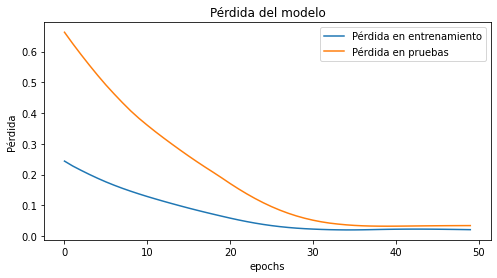

In [55]:
graficar_model_loss(history)

In [56]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

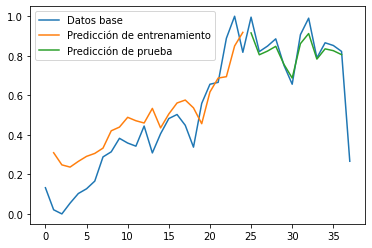

In [57]:
history_model_plot(dataset, look_back, trainPredict, testPredict)


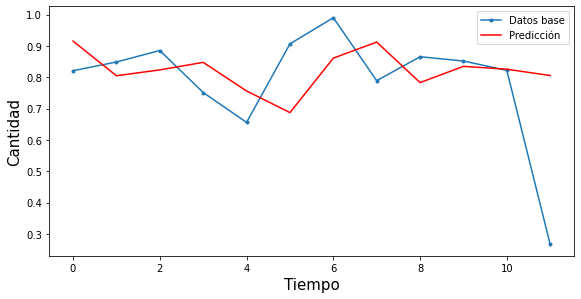

In [58]:
prediction_plot(testY, testPredict, testY.shape[0])